In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import os


In [2]:
df = pd.read_pickle('../../data/all_with_candidates.pickle')

# Label purity

# GO purity

In [3]:
def extract_terms(go_string):
    if pd.isna(go_string):
        return None
    return set(term.strip() for term in go_string.split(';') if term.strip())


In [4]:
# To query GO Terms from UniProt https://www.uniprot.org/id-mapping, please copy everything over
' '.join(df['protein_ac'])

'Q9HBI6 P33151 Q9H0W5 Q8TAP6 Q9P209 P40121 Q8NEF3 Q5VTM2 P24864 Q9UHD1 P09564 P09603 Q9BS18 O15078 Q9BZP3 Q5M9N0 Q96LT6 Q9HCU4 O43852 Q9BWT7 Q53HC0 O15234 Q96KN2 P63098 P55289 O75150 P30837 Q13042 Q8N684 Q5JTY5 P51648 Q9UNA3 O43315 Q12860 O95817 Q02318 Q5VV41 O95931 A6NFN9 Q5T7R7 Q7L4P6 Q9NQW8 O15204 P0CG41 Q8IV38 Q92843 Q9UIV1 A4FU28 Q9NX38 Q9UBD9 O96018 P51636 P46100 O94805 P02656 Q96DR7 O00213 P23946 Q8IYS8 Q8TAM1 Q6ZW61 Q8NDY3 Q5TG92 Q9NPB3 Q7Z6R9 Q9H425 Q86TU6 Q8N8L6 P01023 Q6ZUJ8 O76090 Q13072 P51800 Q86Y29 Q9NPU4 Q86Y27 P07711 Q86VB7 P56945 Q9Y471 Q96MT4 Q9H1Z8 Q96CW1 Q9NQ89 Q96RK4 Q9NXU5 Q8N999 O94779 O95406 Q3KR37 Q495D7 Q17RA5 Q9H9P2 P05090 Q9BXU9 Q9P281 Q10589 Q6ZVT6 Q01850 Q9NZP8 Q9NXL2 Q96LR9 Q8NCQ2 Q8IWZ6 Q6PI25 Q9NYM9 P51451 Q9BSY4 O95393 Q13825 Q99653 Q96KC9 P0C842 A0A1B0GTC6 P40616 P63104 P00746 Q8IZS7 Q9GZX7 Q8N5I9 Q8TBE1 Q13085 A8K2U0 Q5SWW7 Q8WXF7 Q9Y294 Q8N9R6 Q9NW68 O14497 Q86TX2 Q9Y4F5 Q86WJ1 P22570 Q9UHR4 Q13795 P29275 P55345 P11712 Q9BZ76 Q5H913 Q8N129 Q9C0A0 Q

In [5]:
go_terms = pd.read_csv('idmapping_2025_07_18.tsv', sep='\t')  # Read query results
go_terms = go_terms.drop_duplicates('Entry').copy()

/var/folders/l3/n75m9_cn5lzbx_tm88xrzhmhcfmwpj/T/ipykernel_60099/2978250557.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  go_terms = pd.read_csv('idmapping_2025_07_18.tsv', sep='\t')  # Read query results


In [6]:
df = pd.read_pickle('../../data/all_with_candidates.pickle')
df = df.merge(go_terms[['Entry', 'Gene Ontology (biological process)', 'Gene Ontology (cellular component)', 'Gene Ontology (GO)', 'Gene Ontology (molecular function)', 'Gene Ontology IDs',]], 'left', left_on='protein_ac', right_on='Entry')

0.8221386366211748


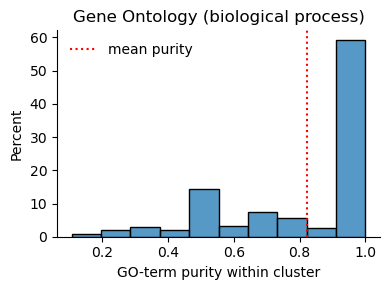

0.9052174250014288


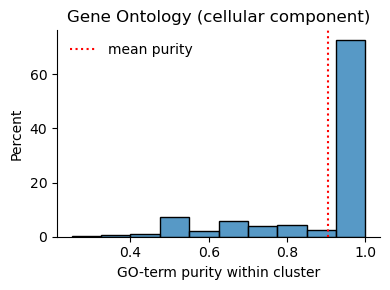

0.8828116663174277


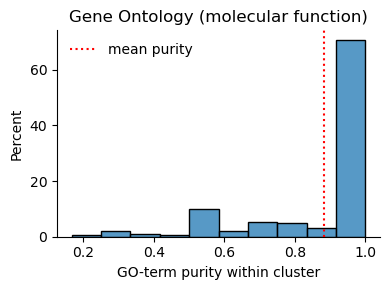

In [7]:
for go_term in ['Gene Ontology (biological process)', 'Gene Ontology (cellular component)', 'Gene Ontology (molecular function)']:
    df_clean = df.copy()
    df_clean['go_terms'] = df_clean[go_term].apply(extract_terms)
    df_clean = df_clean[df_clean['go_terms'].notna()]
    
    purity_stats = []
    
    for cluster, group in df_clean.groupby('cov_0.1_min_seq_id_0.1_e_0.001_cluster'):
        go_to_proteins = defaultdict(list)
        for idx, row in group.iterrows():
            for term in row['go_terms']:
                go_to_proteins[term].append(idx)
    
        most_common_term, proteins_with_term = max(go_to_proteins.items(), key=lambda x: len(x[1]))
        num_with_term = len(proteins_with_term)
        total_proteins = len(group)
        purity = num_with_term / total_proteins
    
        purity_stats.append({
            'cluster': cluster,
            'total_proteins': total_proteins,
            'most_common_term': most_common_term,
            'num_proteins_with_term': num_with_term,
            'purity': purity
        })
    
    purity_df = pd.DataFrame(purity_stats)

    print(purity_df[purity_df['total_proteins'] > 1]['purity'].mean())

    plt.figure(figsize=(4, 3))
    sns.histplot(purity_df[purity_df['total_proteins'] > 1], x='purity', stat='percent', bins=10)
    plt.axvline(purity_df[purity_df['total_proteins'] > 1]['purity'].mean(), c='r', ls=':', label='mean purity')
    plt.legend(frameon=False)
    sns.despine()
    plt.xlabel('GO-term purity within cluster')
    plt.title(go_term)
    plt.tight_layout()
    plt.savefig(f'GO-purity_{go_term}.pdf')
    plt.show()

# Cluster size

In [8]:
df['cluster_size'] = df.groupby('cov_0.1_min_seq_id_0.1_e_0.001_cluster')['cov_0.1_min_seq_id_0.1_e_0.001_cluster'].transform('count')

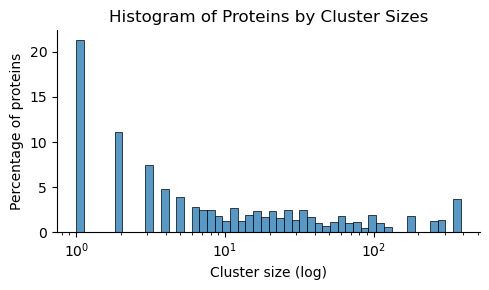

In [9]:
plt.figure(figsize=(5, 3))
sns.histplot(df, x='cluster_size', stat='percent', bins=50, log_scale=(True, False))
sns.despine()
# plt.yscale('log')
plt.xlabel("Cluster size (log)")
plt.ylabel("Percentage of proteins")
plt.title("Histogram of Proteins by Cluster Sizes")
plt.tight_layout()
plt.savefig(f'cluster_size_hist.pdf')
plt.show()

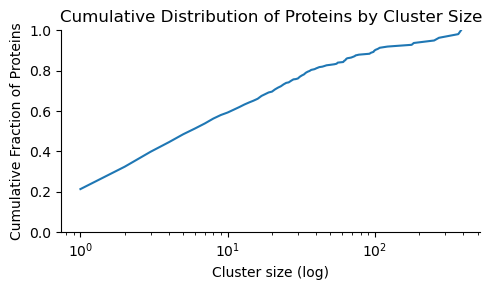

In [10]:
cluster_size_distribution = df['cluster_size'].value_counts().sort_index()
cumsum = cluster_size_distribution.cumsum()
relative_cumsum = cumsum / cumsum.iloc[-1]
relative_cumsum_df = relative_cumsum.reset_index()
relative_cumsum_df.columns = ['cluster_size', 'relative_cumsum']
plt.figure(figsize=(5, 3))
sns.lineplot(relative_cumsum_df, x='cluster_size', y='relative_cumsum')
sns.despine()
plt.title('Cumulative Distribution of Proteins by Cluster Size')
plt.xlabel('Cluster size (log)')
plt.ylabel('Cumulative Fraction of Proteins')
plt.ylim(0, 1)
plt.xscale('log')
plt.tight_layout()
plt.savefig(f'cluster_size_cumulative_plot.pdf')
plt.show()

In [11]:
relative_cumsum_df.head(10)

,cluster_size,relative_cumsum
0,1,0.213275
1,2,0.324271
2,3,0.398482
3,4,0.446094
4,5,0.485280
5,6,0.513495
6,7,0.538526
7,8,0.562821
8,9,0.580456
9,10,0.592701
